In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [8]:
bond1 = 'Price History_20+_US_TBills.xlsx'
bond2 = 'Price History_7-10_US_TBills.xlsx'
equity = 'Price History_IVV_US_Equity.xlsx'
gold = 'Price History_IAU_Gold_Trust.xlsx'
# Load the Excel file into a DataFrame
df = pd.read_excel(bond1)


In [20]:
def equal_risk_contribution_optimization(file_paths, initial_money):
    """
    Implements Equal Risk Contribution (ERC) portfolio optimization.
    Args:
        file_paths (list): List of file paths to the Excel files for each asset.
        initial_money (float): Total initial amount of money to invest.
    Returns:
        dict: Final portfolio value, optimized weights, and performance metrics.
    """
    # Remove duplicate file paths
    unique_file_paths = list(set(file_paths))
    
    # Load data and calculate daily returns for each asset
    returns_data = []
    for file_path in unique_file_paths:
        # Load Excel file into DataFrame
        data = pd.read_excel(file_path)
        data['Exchange Date'] = pd.to_datetime(data['Exchange Date'], errors='coerce')
        data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
        data = data.dropna(subset=['Exchange Date', 'Close'])
        data = data.sort_values(by='Exchange Date')  # Sort by date

        # Calculate daily returns
        data['Daily Return'] = data['Close'].pct_change().dropna()
        returns_data.append(data[['Exchange Date', 'Daily Return']].set_index('Exchange Date'))
    
    # Combine all assets' returns into one DataFrame
    combined_returns = pd.concat(returns_data, axis=1, keys=[f"Asset_{i}" for i in range(len(returns_data))])
    combined_returns.columns = [f"Asset_{i}" for i in range(len(returns_data))]
    combined_returns = combined_returns.dropna()  # Drop rows with missing values

    # Calculate mean returns and covariance matrix
    mean_returns = combined_returns.mean()
    cov_matrix = combined_returns.cov()

    # --- Diagnostic: Print Covariance and Correlation Matrix ---
    print("\nCovariance Matrix:")
    print(cov_matrix)
    print("\nCorrelation Matrix:")
    print(combined_returns.corr())

    # Function to calculate portfolio volatility
    def portfolio_volatility(weights, cov_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Function to calculate marginal risk contribution
    def marginal_risk_contribution(weights, cov_matrix):
        portfolio_vol = portfolio_volatility(weights, cov_matrix)
        # Marginal risk contribution for each asset
        marginal_contrib = np.dot(cov_matrix, weights) / portfolio_vol
        return marginal_contrib

    # Function to calculate risk contributions
    def risk_contributions(weights, cov_matrix):
        portfolio_vol = portfolio_volatility(weights, cov_matrix)
        marginal_contrib = marginal_risk_contribution(weights, cov_matrix)
        risk_contrib = weights * marginal_contrib
        return risk_contrib

    # ERC Optimization function (minimize difference in risk contributions)
    def objective(weights, cov_matrix, tolerance=0.05):
        risk_contrib = risk_contributions(weights, cov_matrix)
        total_risk = portfolio_volatility(weights, cov_matrix)
        # Target risk contribution
        target_risk_contrib = total_risk / len(weights)
        
        # Allowing a tolerance for minor deviations in risk contributions
        risk_diff = np.sum(np.abs(risk_contrib - target_risk_contrib))
        
        return risk_diff

    # Constraints and bounds
    num_assets = len(mean_returns)
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]  # Sum of weights = 1
    bounds = [(0, 1) for _ in range(num_assets)]  # No short-selling

    # Initial guess (equal weights)
    initial_weights = np.array([1 / num_assets] * num_assets)

    # Run the optimization
    result = minimize(objective, initial_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    optimized_weights = result.x

    # Debugging: Check final optimized weights
    print("\nOptimized Weights:")
    for i, weight in enumerate(optimized_weights):
        print(f"Asset {i}: {weight:.4f}")

    # Calculate portfolio value over time using cumulative product of returns
    portfolio_returns = (combined_returns @ optimized_weights)
    portfolio_values = (1 + portfolio_returns).cumprod() * initial_money  # Cumulative product of returns

    # Metrics
    starting_value = initial_money
    ending_value = portfolio_values.iloc[-1]
    total_days = (portfolio_values.index[-1] - portfolio_values.index[0]).days
    total_years = total_days / 365.0
    
    # 1. CAGR
    cagr = ((ending_value / starting_value) ** (1 / total_years)) - 1
    
    # 2. Volatility (Standard Deviation of Daily Returns)
    volatility = portfolio_returns.std() * np.sqrt(252)  # Annualized volatility
    
    # 3. Max Drawdown
    rolling_max = portfolio_values.cummax()
    drawdowns = (portfolio_values - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()
    
    # 4. Sharpe Ratio (assuming risk-free rate = 0 for simplicity)
    sharpe_ratio_value = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
    
    # 5. Value at Risk (99% Confidence)
    var_99 = portfolio_returns.quantile(0.01)  # 1st percentile of returns

    # Plot portfolio value over time
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_values.index, portfolio_values, label='Portfolio Value (ERC)', color='purple')
    plt.title("Portfolio Growth Over Time (Equal Risk Contribution)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (USD)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Return metrics and results
    return {
        "Final Portfolio Value": f"${ending_value:,.2f}",
        "Optimized Weights": {f"Asset_{i}": f"{weight:.2%}" for i, weight in enumerate(optimized_weights)},
        "CAGR": f"{cagr:.2%}",
        "Volatility": f"{volatility:.2%}",
        "Max Drawdown": f"{max_drawdown:.2%}",
        "Sharpe Ratio": f"{sharpe_ratio_value:.2f}",
        "99% VaR": f"{var_99:.2%} (daily loss threshold)"
    }

In [21]:
capital = 1000000
files = [gold, equity, bond1]


Covariance Matrix:
          Asset_0   Asset_1   Asset_2
Asset_0  0.000123  0.000017  0.000007
Asset_1  0.000017  0.000087 -0.000037
Asset_2  0.000007 -0.000037  0.000143

Correlation Matrix:
          Asset_0   Asset_1   Asset_2
Asset_0  1.000000  0.166082  0.052184
Asset_1  0.166082  1.000000 -0.328091
Asset_2  0.052184 -0.328091  1.000000

Optimized Weights:
Asset 0: 0.2667
Asset 1: 0.4039
Asset 2: 0.3293


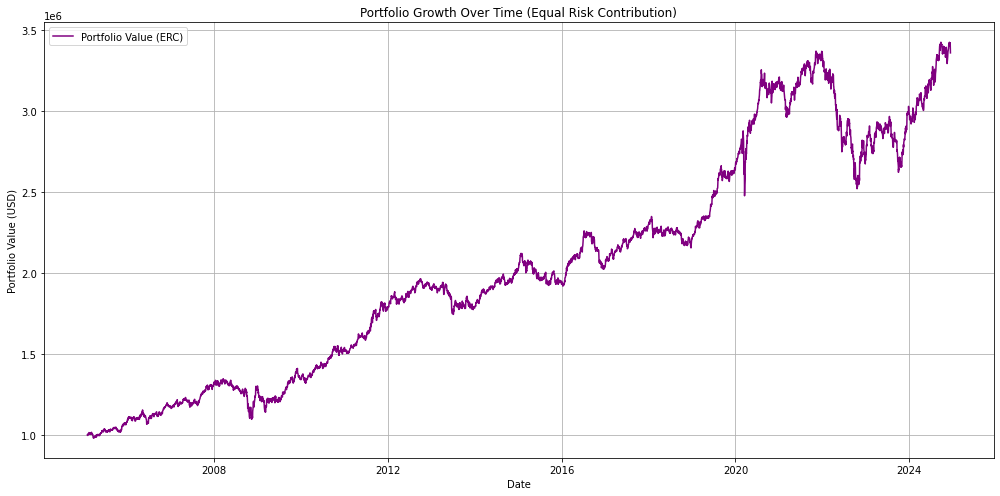

{'Final Portfolio Value': '$3,360,636.73',
 'Optimized Weights': {'Asset_0': '26.67%',
  'Asset_1': '40.39%',
  'Asset_2': '32.93%'},
 'CAGR': '6.29%',
 'Volatility': '9.22%',
 'Max Drawdown': '-25.20%',
 'Sharpe Ratio': '0.71',
 '99% VaR': '-1.52% (daily loss threshold)'}

In [22]:
equal_risk_contribution_optimization(files, capital)